In [235]:
import surprise
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from tqdm.auto import tqdm

sns.set_style("whitegrid")

## Load the dataset

In [236]:
df_plantnet = pd.read_parquet("./data/recsys_interactions_minimal.parquet")
df_plantnet.head()

,obs_id,item_id,user_id,user_weight,interaction_type,value,obs_author,number_of_items,AI_determination_1,AI_score_1,...,observation_time,observation_year,observation_month,interaction_time_gap,user_determination_family,user_determination_genus,AI_determination_1_family,AI_determination_1_genus,AI_determination_2_family,AI_determination_2_genus
index,,,,,,,,,,,,,,,,,,,,,
1096,1001018503,None,100256658,9.81,determination,None,100484701,2,Cuphea micropetala Kunth,0.54508,...,1510175067000,2017,11,0,None,None,Lythraceae,Cuphea,Campanulaceae,Lobelia
1097,1001018503,50cab54f2ea7ccf60c54263423bb2bf1307a4ba7,100256658,9.81,quality,False,100484701,2,Cuphea micropetala Kunth,0.54508,...,1510175067000,2017,11,0,None,None,Lythraceae,Cuphea,Campanulaceae,Lobelia
1098,1001018503,50cab54f2ea7ccf60c54263423bb2bf1307a4ba7,100385054,0.74,quality,False,100484701,2,Cuphea micropetala Kunth,0.54508,...,1510175067000,2017,11,0,None,None,Lythraceae,Cuphea,Campanulaceae,Lobelia
1099,1001018503,50cab54f2ea7ccf60c54263423bb2bf1307a4ba7,100465488,11.44,noplant,None,100484701,2,Cuphea micropetala Kunth,0.54508,...,1510175067000,2017,11,0,None,None,Lythraceae,Cuphea,Campanulaceae,Lobelia
1100,1001018503,None,100484701,4.00,determination,Lobelia laxiflora Kunth,100484701,2,Cuphea micropetala Kunth,0.54508,...,1510175067000,2017,11,632,Campanulaceae,Lobelia,Lythraceae,Cuphea,Campanulaceae,Lobelia


In [237]:
def preprocess_plantnet_data(
    logs_path,
    min_number_of_reviews=50,
    min_number_of_participations=50,
    balanced_classes=False,
):
    print("Preparing ratings log")
    logs = pd.read_parquet(logs_path)
    obs_counts = logs["obs_id"].value_counts()
    obs_to_keep = (
        pd.DataFrame(obs_counts)
        .loc[pd.DataFrame(obs_counts)["count"] >= min_number_of_reviews]
        .index
    )
    logs = logs.loc[logs["obs_id"].isin(obs_to_keep)]
    logs["rating"] = logs["interaction_type"].map(
        {"determination": 1, "quality": 0, "noplant": 0, "organ": 0, "malformed": 0}
    )
    logs = (
        logs[["user_id", "obs_id", "rating"]]
        .groupby(["user_id", "obs_id"])
        .sum()
        .reset_index()
    )
    logs.loc[logs["rating"] > 10, "rating"] = 10
    interactions_count = logs["user_id"].value_counts()
    user_to_keep = (
        pd.DataFrame(interactions_count)
        .loc[pd.DataFrame(interactions_count)["count"] >= min_number_of_participations]
        .index
    )
    logs = logs.loc[logs["user_id"].isin(user_to_keep)]

    if balanced_classes is True:
        print("Balancing")
        logs = logs.groupby("obs_id")
        logs = logs.apply(lambda x: x.sample(logs.size().min()).reset_index(drop=True))
    print("Shuffling")
    logs = logs.sample(frac=1)
    logs["t"] = np.arange(len(logs))
    logs.index = logs["t"]
    print(
        f"""
    Keeping: {logs["obs_id"].nunique()} obs and {logs["user_id"].nunique()} user with a total of {logs.shape} interations
"""
    )
    le_user = preprocessing.LabelEncoder()
    le_item = preprocessing.LabelEncoder()
    logs["user_id"] = le_user.fit_transform(logs["user_id"])
    logs["obs_id"] = le_item.fit_transform(logs["obs_id"])
    return logs, le_user, le_item

In [249]:
logs, le_user, le_item = preprocess_plantnet_data(
    "./data/recsys_interactions_minimal.parquet",
    min_number_of_reviews=20,
    min_number_of_participations=100,
)
logs.drop("t", inplace=True, axis=1)
logs.columns = ["user_id", "item_id", "response"]

Preparing ratings log
Shuffling

    Keeping: 54017 obs and 290 user with a total of (192352, 4) interations



In [239]:
logs.head()

,user_id,item_id,response
t,,,
0,29,46695,1
1,50,48040,1
2,30,47369,1
3,198,13813,1
4,14,15283,1


## Train/Test split

In [240]:
def stratified_split(data, test_size=0.2):
    train_data = pd.DataFrame()
    test_data = pd.DataFrame()

    # Perform stratified split by user
    for user_id, user_data in data.groupby("user_id"):
        user_train, user_test = train_test_split(
            user_data, test_size=test_size, random_state=42
        )
        train_data = pd.concat([train_data, user_train])
        test_data = pd.concat([test_data, user_test])

    return train_data.reset_index(drop=True), test_data.reset_index(drop=True)

train_log, test_log = stratified_split(logs)

## Create user and item features

In [241]:
cols = [
            "obs_id",
            "number_of_items",
            "AI_determination_1",
            "AI_score_1",
            "AI_determination_2",
            "AI_score_2",
            "observation_month",
            "observation_year",
            "AI_determination_1_family",
            "AI_determination_1_genus",
            "AI_determination_2_family",
            "AI_determination_2_genus",
]
items_to_record = le_item.classes_
tmp = df_plantnet.loc[df_plantnet["obs_id"].isin(items_to_record)].drop_duplicates(
    subset="obs_id", keep="last"
)
item_features = tmp[cols]
item_features.rename(columns={"obs_id": "item_id"}, inplace=True)
item_features["item_id"] = le_item.transform(item_features["item_id"])
item_features.head()

/tmp/ipykernel_785443/3226098952.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  item_features.rename(columns={"obs_id": "item_id"}, inplace=True)
/tmp/ipykernel_785443/3226098952.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  item_features["item_id"] = le_item.transform(item_features["item_id"])


,item_id,number_of_items,AI_determination_1,AI_score_1,AI_determination_2,AI_score_2,observation_month,observation_year,AI_determination_1_family,AI_determination_1_genus,AI_determination_2_family,AI_determination_2_genus
index,,,,,,,,,,,,
187651,158,3,Papaver somniferum L.,0.98235,Solanum sisymbriifolium Lam.,0.09255,6,2018,Papaveraceae,Papaver,Solanaceae,Solanum
235590,144,3,Brachychiton populneus (Schott & Endl.) R.Br.,0.73845,Liquidambar formosana Hance,0.10040,10,2017,Malvaceae,Brachychiton,Altingiaceae,Liquidambar
337807,3324,3,Solidago virgaurea L.,0.69822,Dittrichia viscosa (L.) Greuter,0.06335,9,2019,Asteraceae,Solidago,Asteraceae,Dittrichia
449241,191,3,Galium verum L.,0.92924,Epilobium angustifolium L.,0.67331,7,2018,Rubiaceae,Galium,Onagraceae,Chamaenerion
459451,47,3,Clinopodium nepeta (L.) Kuntze,0.42701,Thymus vulgaris L.,0.06487,11,2017,Lamiaceae,Clinopodium,Lamiaceae,Thymus


In [242]:
cols = [
    "user_id",
    "user_weight",
    "obs_id",
    "value",
    "obs_author",
    "interaction_type",
    "interaction_time_gap",
    "user_determination_family",
    "user_determination_genus",
    "AI_determination_1",
]
users_to_record = le_user.classes_

tmp = df_plantnet.loc[df_plantnet["obs_id"].isin(le_item.classes_)][cols]
tmp.head()

,user_id,user_weight,obs_id,value,obs_author,interaction_type,interaction_time_gap,user_determination_family,user_determination_genus,AI_determination_1
index,,,,,,,,,,
187628,100195956,21.68,1002394636,True,100532518,quality,0,None,None,Papaver somniferum L.
187629,100195956,21.68,1002394636,True,100532518,quality,0,None,None,Papaver somniferum L.
187630,100236907,14.91,1002394636,True,100532518,quality,0,None,None,Papaver somniferum L.
187631,100236907,14.91,1002394636,True,100532518,quality,0,None,None,Papaver somniferum L.
187632,100238134,15.59,1002394636,True,100532518,quality,0,None,None,Papaver somniferum L.


In [243]:
user_features = {
    "user_id": [],
    "weight": [],
    "determination": [],
    "quality": [],
    "organ": [],
    "malformed": [],
    "noplant": [],
    "number_author_obs": [],
    "number_determination_not_ai": [],
}
for i in range(1, 6):
    for cl in ["family", "genus", "species"]:
        user_features[f"top_{i}_{cl}"] = []

In [244]:
users_to_record = le_user.classes_
tmp = tmp[tmp["user_id"].isin(users_to_record)]

for j in tqdm(tmp["user_id"].unique()):
    user_features["user_id"].append(le_user.transform([j])[0])
    tmp2 = tmp[tmp["user_id"] == j]
    user_features["weight"].append(tmp2.user_weight.iloc[0])
    vc = tmp2["interaction_type"].value_counts()
    for cl_ in ["determination", "quality", "organ", "malformed", "noplant"]:
        if cl_ in vc.index:
            user_features[cl_].append(vc[cl_])
        else:
            user_features[cl_].append(0)
    inter_ = tmp2[tmp2["interaction_type"] == "determination"]
    species_inter = inter_["value"].value_counts()
    family_inter = inter_["user_determination_family"].value_counts()
    genus_inter = inter_["user_determination_genus"].value_counts()
    for i in range(1,6):
        user_features[f"top_{i}_species"].append(species_inter.index[i])
        user_features[f"top_{i}_family"].append(family_inter.index[i])
        user_features[f"top_{i}_genus"].append(genus_inter.index[i])
    user_features["number_author_obs"].append(tmp2[
            tmp2["user_id"] == tmp2["obs_author"]
        ].drop_duplicates(subset="obs_id", keep="last").shape[0]
        )
    user_features["number_determination_not_ai"].append(
            inter_[inter_["value"] != inter_["AI_determination_1"]]
            .drop_duplicates(subset="obs_id", keep="last")
            .shape[0]
        )

  0%|          | 0/290 [00:00<?, ?it/s]

In [245]:
user_features = pd.DataFrame(user_features)
print(user_features.columns)
user_features.head()

Index(['user_id', 'weight', 'determination', 'quality', 'organ', 'malformed',
       'noplant', 'number_author_obs', 'number_determination_not_ai',
       'top_1_family', 'top_1_genus', 'top_1_species', 'top_2_family',
       'top_2_genus', 'top_2_species', 'top_3_family', 'top_3_genus',
       'top_3_species', 'top_4_family', 'top_4_genus', 'top_4_species',
       'top_5_family', 'top_5_genus', 'top_5_species'],
      dtype='object')


,user_id,weight,determination,quality,organ,malformed,noplant,number_author_obs,number_determination_not_ai,top_1_family,...,top_2_species,top_3_family,top_3_genus,top_3_species,top_4_family,top_4_genus,top_4_species,top_5_family,top_5_genus,top_5_species
0,9,21.68,768,3893,2049,0,0,114,140,Fabaceae,...,Papaver rhoeas L.,Caprifoliaceae,Rosa,Echinops ritro L.,Lamiaceae,Prunella,Centaurea scabiosa L.,Ranunculaceae,Vinca,Blackstonia perfoliata (L.) Huds.
1,12,14.91,810,3389,2068,0,0,70,143,Rosaceae,...,Silene latifolia Poir.,Lamiaceae,Centaurea,Tragopogon pratensis L.,Ranunculaceae,Tragopogon,Silybum marianum (L.) Gaertn.,Boraginaceae,Philadelphus,Anacamptis pyramidalis (L.) Rich.
2,13,15.59,587,3218,1524,0,0,53,109,Rosaceae,...,Papaver rhoeas L.,Lamiaceae,Rosa,Centaurea scabiosa L.,Ranunculaceae,Prunella,Echium vulgare L.,Caryophyllaceae,Silybum,Convolvulus cantabrica L.
3,16,16.69,576,2621,1386,0,0,37,111,Rosaceae,...,Lotus corniculatus L.,Caryophyllaceae,Papaver,Prunella vulgaris L.,Lamiaceae,Lotus,Knautia arvensis (L.) Coult.,Ranunculaceae,Campanula,Echium vulgare L.
4,17,12.82,612,2651,1509,0,0,19,112,Fabaceae,...,Catananche caerulea L.,Ranunculaceae,Papaver,Oenothera biennis L.,Caryophyllaceae,Geum,Paeonia officinalis L.,Lamiaceae,Lotus,Hydrangea macrophylla (Thunb.) Ser.


## Create user features based on latent factor models

In [246]:
from surprise import BaselineOnly, Dataset, Reader, SVD, accuracy

reader = Reader(rating_scale=(0, 1))

train_log.columns = ["userID", "itemID", "rating"]
test_log.columns = ["userID", "itemID", "rating"]

userRatings_data_train = Dataset.load_from_df(train_log, reader).build_full_trainset()
userRatings_data_test = (
    Dataset.load_from_df(test_log, reader).build_full_trainset().build_testset()
)
# logs.columns = ["userID", "itemID", "rating"]
# logs_surprise = Dataset.load_from_df(logs, reader).build_full_trainset()
algo = SVD(biased=False)
algo.fit(userRatings_data_train)
features_users_svd = algo.pu
features_items_svd = algo.qi
# print(features_users_svd)
# predictions = algo.test(userRatings_data_test)
# accuracy.rmse(predictions, verbose=True)  # ~ 0.68

In [226]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=50, random_state=0, n_init="auto").fit(features_users_svd)
kmeans.labels_

array([ 1,  1,  1, 42, 34,  7,  1, 20, 42, 12, 47,  1, 15, 15, 14, 42, 15,
       15,  1, 15,  3, 12,  1, 35, 17,  3, 42,  3, 44, 14, 14,  1, 42,  3,
        3, 10,  1,  1,  1, 16,  1,  1, 31, 42,  3, 19, 42, 42, 42,  3,  3,
       30,  1,  1, 42,  1,  1,  1, 42,  1,  1, 42,  3,  1,  3, 32, 12,  1,
       42, 46,  1,  1,  1,  1, 42, 40, 42, 44, 10, 42,  1,  3,  3,  3,  3,
       32, 42, 42,  1, 27,  1, 42, 42, 42,  1,  3,  1, 38,  1, 42,  3,  1,
       42, 10,  1,  1, 13, 36,  1, 42, 29, 42,  1,  1, 10,  1,  1,  1,  3,
       49, 42, 42, 32,  1,  1,  1, 28,  0,  1,  1,  1, 42,  1,  3,  1,  1,
       42,  1, 48,  1, 11,  1,  3, 10,  1, 42,  3, 14,  1,  1, 42, 42,  1,
        3,  1, 42,  3,  1,  1,  0, 42,  3, 42, 10, 14,  1, 22,  1, 42,  1,
       42, 44,  2, 10, 10,  3, 14,  1,  1,  1,  3, 42, 44, 37,  1,  3, 25,
        3,  3, 26,  3,  1, 42,  1,  9, 44, 44,  1,  1,  8,  1, 42, 24,  3,
       10,  1, 41,  3,  1,  1, 42, 10, 10, 42, 21, 10, 10,  2, 39, 10, 42,
        3, 42, 42, 43, 42

## Run bandit recommender systems

In this case, we do not enforce constraints on the labeling system

  0%|          | 0/192352 [00:00<?, ?it/s]

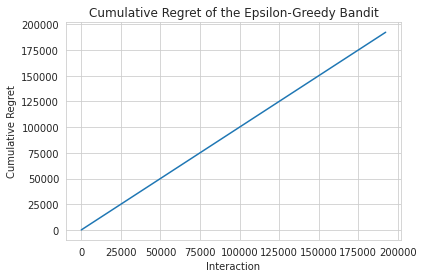

In [252]:
from collections import defaultdict

# Bandit parameters
num_items = logs["item_id"].nunique()
epsilon = 0.1  # exploration factor
Q = defaultdict(float)  # estimated reward for each item
N = defaultdict(int)  # count of selections for each item
cumulative_regret = []
optimal_rewards = logs.groupby("user_id")["response"].max().to_dict()

for index, row in tqdm(logs.iterrows(), total=len(logs)):
    user_id = row["user_id"]
    item_id = row["item_id"]
    reward = row["response"]

    # Exploration vs Exploitation
    if np.random.rand() < epsilon:
        recommended_item = np.random.choice(logs["item_id"].unique())
    else:
        recommended_item = (
            max(Q, key=Q.get) if Q else np.random.choice(logs["item_id"].unique())
        )

    observed_reward = reward if recommended_item == item_id else 0
    optimal_reward = optimal_rewards.get(user_id, 0)
    regret = optimal_reward - observed_reward
    cumulative_regret.append(regret if regret > 0 else 0)
    N[recommended_item] += 1
    Q[recommended_item] += (observed_reward - Q[recommended_item]) / N[recommended_item]

cumulative_regret = np.cumsum(cumulative_regret)


plt.plot(cumulative_regret)
plt.xlabel("Interaction")
plt.ylabel("Cumulative Regret")
plt.title("Cumulative Regret of the Epsilon-Greedy Bandit")
plt.show()

## Enforce weight constraint

We monitor how much votes were casted and how much vote we in fact need. This efficiency criterion shows the need for personalized interactions in crowdsourcing settings.